## 0. Prepare Environment
본격적인 개발에 앞서 필요한 환경을 구축합니다. 다음과 같은 순서로 구성됩니다.
1. 라이브러리 설치
2. 구글 드라이브 연결
3. 라이브러리 불러오기
4. 데이터파일 복사해서 불러오기
5. CUDA 세팅하기
6. 랜덤 시드 설정하기

### 라이브러리 설치
필요한 라이브러리를 설치합니다.  
노트북 환경에서는 **느낌표(!)를 이용하여 셀 명령어를 실행**시킬 수 있습니다.

In [1]:
!pip install timm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.0 MB/s 


In [2]:
!nvidia-smi

Fri Jul 22 05:23:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Library

In [4]:
import torch
import timm
import os
import random

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from datetime import datetime

%matplotlib inline

### Copy data files

In [5]:
!cp /content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/data/data.zip .
!cp /content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/sample_submission.csv .
!unzip -qq data.zip -d .

### Cuda Setting

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Set Random Seed

In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. 데이터 전처리하기
1. Define Dataset Class
2. Define Data Transform
3. Make Train/Valid Dataset
4. Make DataLoader

### Define Dataset Class


In [8]:
class CustomSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.indices = self.subset.indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


class TestDataset(Dataset):
    def __init__(self, root='./test', transform=None):
        self.root = root
        self.data = os.listdir(self.root)
        self.data = sorted(self.data)
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.data[idx]))
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.data)


### Define Data Transform


In [9]:
transform = {
    'train': transforms.Compose([transforms.Resize((256, 256)),
                                 #transforms.RandomResizedCrop((224, 224)),
                                 #transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
             
    'valid': transforms.Compose([transforms.Resize((256, 256)),
                                 #transforms.CenterCrop((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
}

## **Cutout: Main Code for Applying Cutout data augmentation**

In [10]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [11]:
cutout = False # Apply Cutout?
if cutout:
    n_holes = 1 # Number of holes to cut out from image
    length = 16 # Length of the holes

In [12]:
if cutout:
    transform['train'].transforms.append(Cutout(n_holes=n_holes, length=length))
    #transform['valid'].transforms.append(Cutout(n_holes=n_holes, length=length))  # valid에 cutout을 추가해야 하나?

### Make Train/Valid Dataset

In [ ]:
all_data = ImageFolder(root='./train')

train_ratio = 0.8
train_data_len = int(len(all_data) * train_ratio)
valid_data_len = len(all_data) - train_data_len
train_data, valid_data = random_split(all_data, [train_data_len, valid_data_len])

train_data = CustomSubset(train_data, transform['train'])
valid_data = CustomSubset(valid_data, transform['valid'])

### Make DataLoader

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

## EDA (Exploratory Data Analysis)
본격적으로 모델을 만들기 전에, **다루고자 하는 데이터가 어떤 특징을 가졌는지 탐색하고 이해하는 것은 매우 중요합니다.**
이 과정을 **탐색적 데이터 분석(EDA)**라고 합니다.
이번 베이스라인 코드에서는 이미지가 어떻게 생겼는지, 개수는 어떠한지 간단하게 파악해보도록 합니다.  
실제 대회에서는 반드시 EDA를 꼼꼼히 진행하여 데이터를 확실히 이해하고 진행할 수 있도록 합시다!

### Train/Dev 데이터 개수

In [ ]:
print("Train/Valid Data Size: " + str(len(all_data)))
print("Train Data Size: " + str(train_data_len))
print("Valid Data Size: " + str(valid_data_len))

Train/Valid Data Size: 18180
Train Data Size: 14544
Valid Data Size: 3636


### Class 개수

In [ ]:
print("Number of Classes: " + str(len(all_data.classes)))
print(all_data.classes[:10])

Number of Classes: 120
['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


### Class 별 Sample 개수

{'Affenpinscher': 130, 'Afghan_hound': 219, 'African_hunting_dog': 149, 'Airedale': 182, 'American_staffordshire_terrier': 144, 'Appenzeller': 131, 'Australian_terrier': 176, 'Basenji': 189, 'Basset': 155, 'Beagle': 175, 'Bedlington_terrier': 162, 'Bernese_mountain_dog': 198, 'Black-and-tan_coonhound': 139, 'Blenheim_spaniel': 168, 'Bloodhound': 167, 'Bluetick': 151, 'Border_collie': 130, 'Border_terrier': 152, 'Borzoi': 131, 'Boston_bull': 162, 'Bouvier_des_flandres': 130, 'Boxer': 131, 'Brabancon_griffon': 133, 'Briard': 132, 'Brittany_spaniel': 132, 'Bull_mastiff': 136, 'Cairn': 177, 'Cardigan': 135, 'Chesapeake_bay_retriever': 147, 'Chihuahua': 132, 'Chow': 176, 'Clumber': 130, 'Cocker_spaniel': 139, 'Collie': 133, 'Curly-coated_retriever': 131, 'Dandie_dinmont': 160, 'Dhole': 130, 'Dingo': 136, 'Doberman': 130, 'English_foxhound': 137, 'English_setter': 141, 'English_springer': 139, 'Entlebucher': 182, 'Eskimo_dog': 130, 'Flat-coated_retriever': 132, 'French_bulldog': 139, 'German

<BarContainer object of 120 artists>

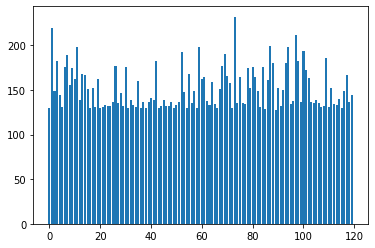

In [ ]:
items = all_data.class_to_idx.items()
idx2class = {v:k for k, v in items}
count_dict = {k:0 for k, v in items}
for item in all_data:
    label = item[1]
    count_dict[idx2class[label]] += 1

print(count_dict)
plt.bar(np.arange(len(count_dict)), count_dict.values())

### 학습데이터 시각화 (no augmentation, augmentation)

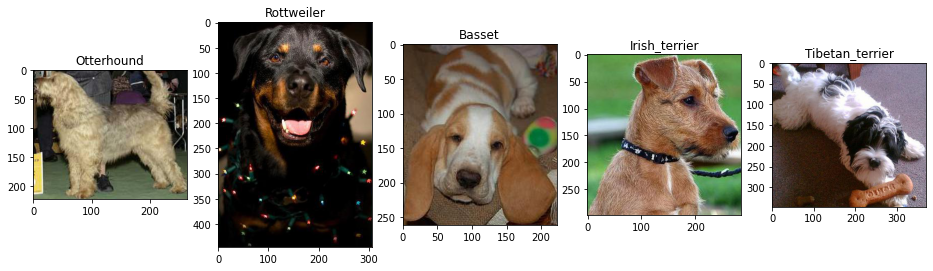

In [ ]:
fig = plt.figure(figsize=(16, 16))
axes = []
idx_to_visualize = random.sample(list(range(len(all_data))), 5)
for i,idx in enumerate(idx_to_visualize):
    image, label = all_data[idx]
    axes.append(fig.add_subplot(1, 5, i+1))
    axes[i].set_title(idx2class[label])
    axes[i].imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


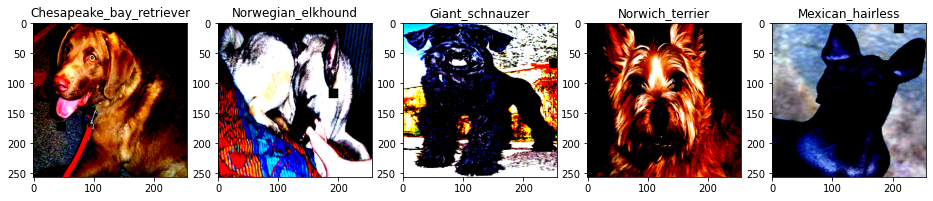

In [ ]:
fig = plt.figure(figsize=(16, 16))
axes = []
idx_to_visualize = random.sample(list(range(train_data_len)), 5)
for i,idx in enumerate(idx_to_visualize):
    image, label = train_data[idx]
    axes.append(fig.add_subplot(1, 5, i+1))
    axes[i].set_title(idx2class[label])
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
plt.show()

## Make Model

In [ ]:
# for checking the number of parameters
# do not modify below
def param_check(model):
    total = 0
    for param in model.parameters():
        total += torch.numel(param)

    print(f'# of parameters : {total}\n')
    return total < 15000000

In [ ]:
# timm library에서 사용 가능한 efficient 모델중 일부
all_densenet_models = timm.list_models('efficientnet*')
all_densenet_models

In [ ]:
model = timm.create_model('efficientnet_lite0', pretrained=False, num_classes=120)
# check the number of parameters
assert param_check(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i for i in range(15, 30)], gamma=0.8)

model = model.to(device)
criterion = criterion.to(device)

# of parameters : 3524728



In [ ]:
print(model)

## 학습 진행하기
모델 학습(train)과 검증(validation)을 진행해봅시다.

In [ ]:
path2weight = '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/'

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_every=10, scheduler=None):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_acc = -np.inf
    start_time = datetime.now()
    try:
        for epoch in range(num_epochs):
            train_loss = 0
            train_acc = 0
            processed = 0
            model.train()
            # training step
            print(f'Epoch [{epoch}] Learning Rate : {get_lr(optimizer)}')
            for i, (data, label) in enumerate(train_loader):
                data, label = data.to(device), label.to(device)
                pred = model(data)
                loss = criterion(pred, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == label).item()
                processed += data.size(0)
                if (i % print_every == 0) or (i == len(train_loader) - 1):
                    print(
                        f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(train_loader) * 100:.2f}%)\t\
                        train loss: {train_loss / processed:.4f}\t\
                        train acc: {train_acc / processed * 100:.4f}%\t\
                        time elapsed: {datetime.now() - start_time}'
                        )
            train_losses.append(train_loss / processed)
            train_accs.append(train_acc / processed)
            print("="*100)

            # validation step
            valid_loss = 0
            valid_acc = 0
            processed = 0
            model.eval()
            with torch.no_grad():
                for i, (data, label) in enumerate(valid_loader):
                    data, label = data.to(device), label.to(device)
                    pred = model(data)
                    loss = criterion(pred, label)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == label).item()
                    processed += data.size(0)
                    if (i % print_every == 0) or (i == len(valid_loader) - 1):
                        print(
                            f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(valid_loader) * 100:.2f}%)\t\
                            valid loss: {valid_loss / processed:.4f}\t\
                            valid acc: {valid_acc / processed * 100:.4f}%\t\
                            time elapsed: {datetime.now() - start_time}'
                            )
                if valid_acc / processed > best_acc:
                    best_acc = valid_acc / processed
                    torch.save(model.state_dict(), path2weight+'efficient_lite0_best.pth')
                    print("Best weight saved!!")
                
                torch.save(model.state_dict(), path2weight+'efficient_lite0_last.pth')
                valid_losses.append(valid_loss / processed)
                valid_accs.append(valid_acc / processed)
            print("="*100)
            if scheduler is not None:
                scheduler.step()
        return train_losses, train_accs, valid_losses, valid_accs
    except KeyboardInterrupt:
        return train_losses, train_accs, valid_losses, valid_accs

In [ ]:
train_losses, train_accs, valid_losses, valid_accs = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=15, device=device, scheduler=scheduler)

Epoch [0] Learning Rate : 0.001
Epoch [0/14](0.22%)	                        train loss: 4.8902	                        train acc: 6.2500%	                        time elapsed: 0:00:00.505276
Epoch [0/14](2.42%)	                        train loss: 5.0933	                        train acc: 1.4205%	                        time elapsed: 0:00:03.703578
Epoch [0/14](4.62%)	                        train loss: 5.0351	                        train acc: 1.0417%	                        time elapsed: 0:00:06.844327
Epoch [0/14](6.81%)	                        train loss: 4.9623	                        train acc: 1.2097%	                        time elapsed: 0:00:09.964906
Epoch [0/14](9.01%)	                        train loss: 4.9406	                        train acc: 1.6006%	                        time elapsed: 0:00:13.145065
Epoch [0/14](11.21%)	                        train loss: 4.9198	                        train acc: 1.7157%	                        time elapsed: 0:00:16.339023
Epoch [0/14](

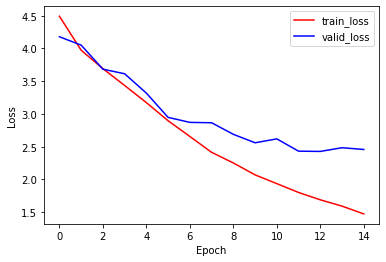

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(train_losses)), train_losses, label='train_loss', color='red')
plt.plot(range(len(valid_losses)), valid_losses, label='valid_loss', color='blue')
plt.legend()
plt.show()

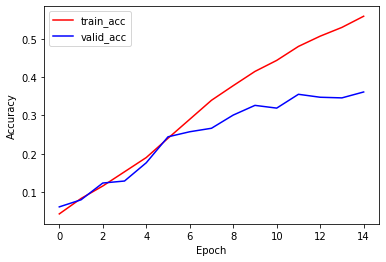

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(len(train_accs)), train_accs, label='train_acc', color='red')
plt.plot(range(len(valid_accs)), valid_accs, label='valid_acc', color='blue')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load(path2weight+'effi_lite0_best.pth'))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
train_losses, train_accs, valid_losses, valid_accs = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=15, device=device, scheduler=scheduler)

Epoch [0] Learning Rate : 0.001
Epoch [0/14](0.22%)	                        train loss: 1.8657	                        train acc: 56.2500%	                        time elapsed: 0:00:00.376606
Epoch [0/14](2.42%)	                        train loss: 1.8683	                        train acc: 48.0114%	                        time elapsed: 0:00:03.604358
Epoch [0/14](4.62%)	                        train loss: 1.8083	                        train acc: 49.5536%	                        time elapsed: 0:00:06.805706
Epoch [0/14](6.81%)	                        train loss: 1.7933	                        train acc: 50.2016%	                        time elapsed: 0:00:10.028573
Epoch [0/14](9.01%)	                        train loss: 1.7758	                        train acc: 50.7622%	                        time elapsed: 0:00:13.205398
Epoch [0/14](11.21%)	                        train loss: 1.7471	                        train acc: 51.9608%	                        time elapsed: 0:00:16.358578
Epoch [

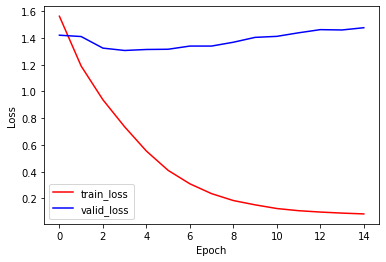

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(train_losses)), train_losses, label='train_loss', color='red')
plt.plot(range(len(valid_losses)), valid_losses, label='valid_loss', color='blue')
plt.legend()
plt.show()

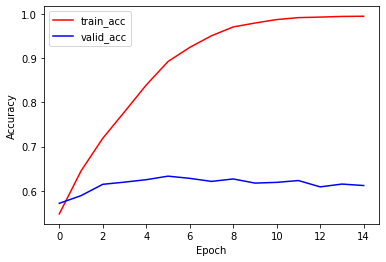

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(len(train_accs)), train_accs, label='train_acc', color='red')
plt.plot(range(len(valid_accs)), valid_accs, label='valid_acc', color='blue')
plt.legend()
plt.show()

## Test Model
학습한 모델을 Test 데이터셋으로 구동해봅시다.
실행 결과는 submission.csv에 담아 Kaggle에 제출해주세요. 


In [ ]:
model.load_state_dict(torch.load(path2weight+'effi_lite0_best.pth'))
model = model.to(device)

In [ ]:
test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     #transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_data = TestDataset(root='./test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def test(model, test_loader, device):
    preds = None
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            if preds is None:
                preds = pred.argmax(1)
            else:
                preds = torch.cat([preds, pred.argmax(1)], dim=0)
    return preds

In [ ]:
preds = test(model, test_loader, device)
submission = pd.read_csv('sample_submission.csv')
submission['Category'] = preds.cpu().numpy()
submission.to_csv('/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/EfficientNet_lite0.csv', index=False)

In [ ]:
model.load_state_dict(torch.load(path2weight+'effi_lite0_last.pth'))
model = model.to(device)
preds = test(model, test_loader, device)
submission = pd.read_csv('sample_submission.csv')
submission['Category'] = preds.cpu().numpy()
submission.to_csv('/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/EfficientNet_lite0_last.csv', index=False)